# Table of Contents
* [Submitting HITs](#Submitting-HITs)
	* [Building URLs for images on s3](#Building-URLs-for-images-on-s3)
	* [submitting HITs in groups](#submitting-HITs-in-groups)
		* [creates HITs, careful with this one](#creates-HITs,-careful-with-this-one)
* [Reviewing HITs](#Reviewing-HITs)
	* [Merging latest round of HITs into combined dataset](#Merging-latest-round-of-HITs-into-combined-dataset)
		* [Loading full dataset if not in memory](#Loading-full-dataset-if-not-in-memory)
	* [Worker Analysis](#Worker-Analysis)
		* [Basic worker stats](#Basic-worker-stats)
			* [HIT duration for pricing](#HIT-duration-for-pricing)
			* [Identifying high and low consensus workers](#Identifying-high-and-low-consensus-workers)
	* [Messaging workers](#Messaging-workers)
* [HIT end-of-life](#HIT-end-of-life)
	* [Pickle latest results](#Pickle-latest-results)
	* [Pickle combined dataset](#Pickle-combined-dataset)
	* [Careful with these](#Careful-with-these)
* [End](#End)


In [680]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

%%capture
import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light default
plt.rcParams['figure.figsize'] = (16.0, 10.0)

import re
from datetime import datetime
import dateutil.parser as dt_parse
import pickle
import boto
import json
import os

from copy import deepcopy
import boto.mturk.connection as tc
import boto.mturk.question as tq
from boto.mturk.qualification import PercentAssignmentsApprovedRequirement, Qualifications, Requirement

from keysTkingdom import mturk_ai2
from keysTkingdom import aws_tokes

import pdfextraction.amt_boto_modules as amt_util

# Submitting HITs

## Building URLs for images on s3

In [681]:
book_groups,ranges = amt_util.load_book_info()

daily_sci_urls = amt_util.make_book_group_urls(book_groups, 'daily_sci', ranges)
spectrum_sci_urls = amt_util.make_book_group_urls(book_groups, 'spectrum_sci', ranges)

## submitting HITs in groups

In [723]:
## Switch between sandbox and the real world here ##
## Don't forget to change submission POST request in the client ##

sandbox_host = 'mechanicalturk.sandbox.amazonaws.com' 
real_world_host = 'mechanicalturk.amazonaws.com'
mturk = tc.MTurkConnection(
    aws_access_key_id = aws_tokes.access_key,
    aws_secret_access_key = aws_tokes.access_secret_key,
    host = real_world_host,
    debug = 1 # debug = 2 prints out all requests.
)
current_account_balance = mturk.get_account_balance()[0]
print current_account_balance # a reminder of sandbox

$355.85


In [812]:
static_params = {
    'title': "Annotate Science Textbook",
    'description': "Choose which category text from a grade-school science book best belongs to",
    'keywords': ['image', 'science', 'text', 'labeling' ],
    'frame_height': 800,
    'amount': 0.06,
    'duration': 3600 * 12,
    'lifetime': 3600 * 24 * 3,
    'max_assignments': 3
}

### creates HITs, careful with this one

In [816]:
pages_to_use = daily_sci_urls[250:500]
expected_cost = len(pages_to_use) *  static_params['amount'] * static_params['max_assignments']
if float(current_account_balance.amount) < expected_cost:
    print('warning- funds are too low')
print('expect this batch of HITs to cost: $' + str(expected_cost))

expect this batch of HITs to cost: $45.0


uncomment cell below only when ready to submit

In [ ]:
amt_util.create_hits_from_pages(mturk, pages_to_use, static_params)

# Reviewing HITs

In [737]:
r_hits_current_batch = amt_util.get_completed_hits(mturk)
assignment_results_current_batch = amt_util.get_assignments(mturk, r_hits_current_batch)

In [739]:
raw_hit_results_current_batch = amt_util.process_raw_hits(assignment_results_current_batch)

In [740]:
results_df_current_batch = amt_util.make_results_df(raw_hit_results_current_batch)
consensus_results_df_current_batch = amt_util.make_consensus_df(results_df_current_batch, 'No Consensus')
results_df_current_batch.head(1)
consensus_results_df_current_batch.head(1)

In [754]:
%%capture
no_consensus_hits = consensus_results_df_current_batch[consensus_results_df_current_batch['category'] == 'No Consensus']

In [781]:
flaw_rate = len(no_consensus_hits) / len(consensus_results_df_current_batch)
print 'text boxes without consensus are ' + '{0:0.2f}% '.format(flaw_rate * 100) + 'of the total'  

text boxes without consensus are 1.70% of the total


In [782]:
amt_util.write_results_df(consensus_results_df_current_batch)

In [790]:
pages_to_review.shape

(5470,)

In [797]:
pages_to_review =pd.unique(consensus_results_df_current_batch['page'])
sample_size = len(pages_to_review) * 5 // 100
sampled_pages_to_review = list(np.random.choice(pages_to_review, size= sample_size, replace=False))
print 'sampling ' + str(sample_size) + ' pages out of ' + str(len(pages_to_review))
to_review = ['start_seq'] + sampled_pages_to_review

sampling 11 pages out of 222


In [799]:
amt_util.review_results(to_review)
print 'posting to review tool, navigate to http://localhost:8080/ and refresh to see the sampled consensus results'

posting to review tool, navigate to http://localhost:8080/ and refresh to see the sampled consensus results


## Merging latest round of HITs into combined dataset  

### Loading full dataset if not in memory


In [708]:
data_pickled_dir = './store_hit_results_metadata/group_latest_combined/' 

In [733]:
# combined_results_df = pd.read_pickle('complete_df.pkl')
# combined_consensus_df = pd.read_pickle('complete_df.pkl')

In [732]:
# combined_results_df = combined_results_df.append(results_df_current_batch)
# combined_consensus_df = amt_util.make_consensus_df(combined_results_df, 'No Consensus')
# combined_consensus_with_workerid_df = amt_util.make_consensus_df_w_worker_id(combined_results_df, consensus_results_df_current_batch)

## Worker Analysis

### Basic worker stats

In [700]:
print 'number of unique workers:'
pd.unique(combined_results_df['worker_id']).shape[0]

number of unique workers:


63

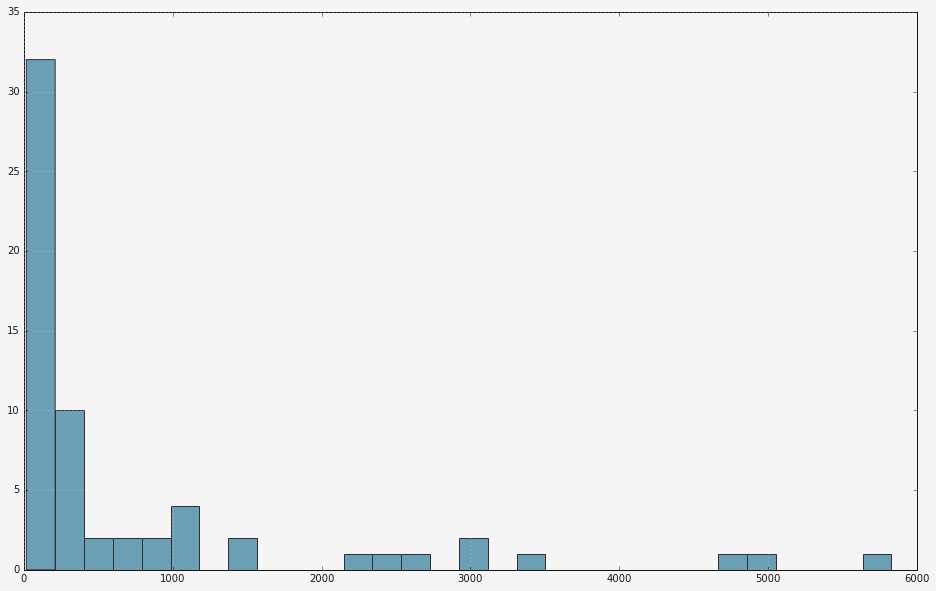

In [565]:
_ = combined_results_df['worker_id'].value_counts().hist(bins= 30)

#### HIT duration for pricing

In [449]:
task_duration_seconds = []
for hit_id, assignments in assignment_results_current_batch.items():
    for assignment in assignments:
        hit_duration = dt_parse.parse(assignment.SubmitTime) - dt_parse.parse(assignment.AcceptTime)
        task_duration_seconds.append(hit_duration.seconds)

In [454]:
task_duration_series = pd.Series(task_duration_seconds)

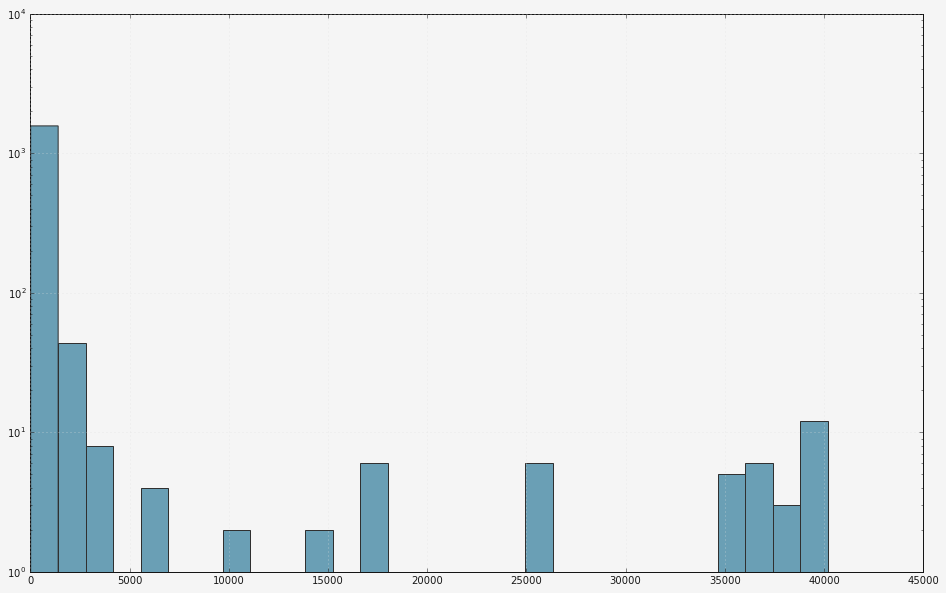

In [457]:
_ = task_duration_series.hist(bins=30, log=True)

In [578]:
winsorized_durations = [t for t in task_duration_seconds if t < 300]
w_duration_series = pd.Series(winsorized_durations)

In [579]:
w_duration_series.mode()

0    20
1    25
dtype: int64

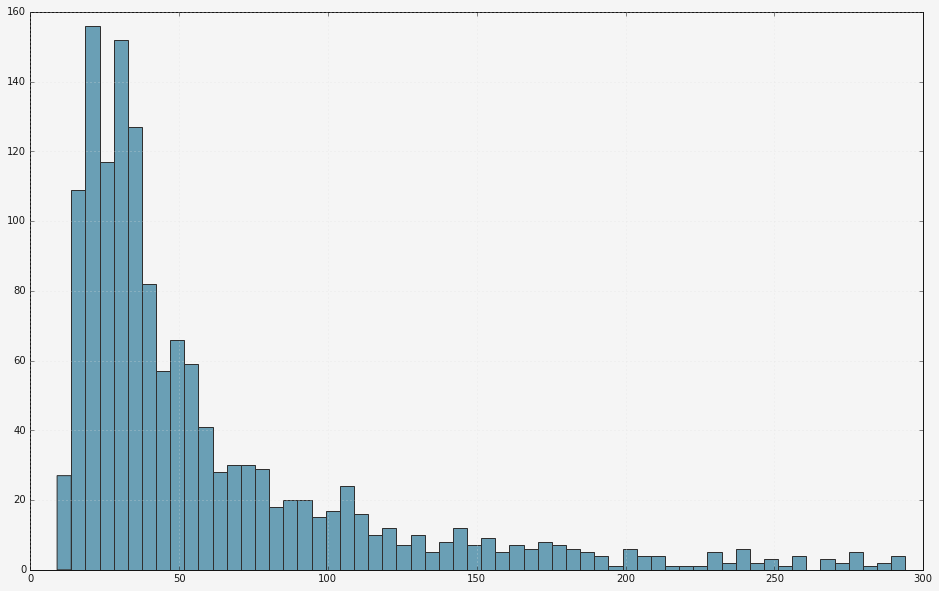

In [592]:
_ = pd.Series(w_duration_series).hist(bins=60)

#### Identifying high and low consensus workers

In [800]:
combined_consensus_with_workerid_df = amt_util.make_consensus_df_w_worker_id(results_df_current_batch, consensus_results_df_current_batch)

In [803]:
worker_conflicts = combined_consensus_with_workerid_df[combined_consensus_with_workerid_df['category'] != combined_consensus_with_workerid_df['consensus_category']]
all_worker_counts = results_df_current_batch['worker_id'].value_counts()
bad_worker_counts = worker_conflicts['worker_id'].value_counts()
worker_quality_df = pd.DataFrame([all_worker_counts, bad_worker_counts]).T
worker_quality_df.columns=['submitted', 'incorrect']
worker_quality_df['hit_perc'] = worker_quality_df['incorrect']/worker_quality_df['submitted']

In [804]:
good_workers = worker_quality_df.sort_values('hit_perc', ascending= True).index.tolist()

In [805]:
suspect_workers = worker_quality_df.sort_values('hit_perc', ascending= False).index.tolist()

In [808]:
worker_quality_df.sort_values('hit_perc', ascending= False).head(10)

,submitted,incorrect,hit_perc
A145AXBDTCIW6Z,25.0,12.0,0.480000
A2LKL8MNCVTPXD,23.0,10.0,0.434783
A18DRAESIN3E94,112.0,43.0,0.383929
A24MVIOAF7SBLP,20.0,7.0,0.350000
AS0RYQU219BQ8,149.0,35.0,0.234899
A3LD1G3R5NOVYH,1130.0,240.0,0.212389
A349UVVFJB3BDG,605.0,122.0,0.201653
A3CKBXOR5HZV78,1020.0,205.0,0.200980
A39SX1QZR36L7A,96.0,17.0,0.177083
AZWDJ0I4IF2TW,121.0,19.0,0.157025


In [704]:
# to_review = ['start_seq'] + list(np.random.choice(pd.unique(results_df[results_df['worker_id'].isin(suspect_workers[:10])]['page']), size= 50, replace=False))
# amt_util.review_results(to_review)

## Messaging workers

In [ ]:
subject = "More science book annotation HITs are available"
message = """
Hello, 

If you're receiving this message you were among the top performers on the first group HITs I submitted.
I've submitted another group of HITs, with more to follow in the next few days. 
I've added some additional instructions, and have removed the default instruction page (they can still be accessed by Read
Instruction Button).

Happy to get any feedback you might have about the HIT.
"""

In [693]:
# _ = mturk.notify_workers(good_workers[:20], subject, message)

# HIT end-of-life

## Pickle latest results

In [712]:
#reset as needed
# gn = 4

In [656]:
next_group = gn + 1
group_n = '_' + str(gn) + '/'

temp_store_dir = './store_hit_results_metadata/group'
try:
    os.mkdir(temp_store_dir + group_n)
except:
    OSError
    
result_file_name = 'hit_info.pkl'
assignment_file_name = 'assignment_info.pkl'
raw_results_file_name = 'raw_res.pkl'
complete_results_file = 'complete_df.pkl'
consensus_results_file = 'consensus_df.pkl'

amt_util.pickle_this(r_hits_batch_2, temp_store_dir + group_n + result_file_name)
amt_util.pickle_this(assignment_results_batch_2, temp_store_dir + group_n + assignment_file_name)
amt_util.pickle_this(raw_hit_results_batch_2, temp_store_dir + group_n + raw_results_file_name)
results_df_batch_2.to_pickle(temp_store_dir + group_n + complete_results_file)
consensus_results_df_batch_2.to_pickle(temp_store_dir + group_n + consensus_results_file)
print 'saved HIT batch number ' + str(gn)
print 'now onto batch ' +str(next_group) 
gn = next_group

## Pickle combined dataset

In [657]:
temp_store_dir = './store_hit_results_metadata/group'
group_n = '_latest_combined/'
try:
    os.mkdir(temp_store_dir + group_n)
except:
    OSError
    
complete_results_file = 'complete_df.pkl'
consensus_results_file = 'consensus_df.pkl'
consensus_results_file_w_workers = 'consensus_df_w_workers.pkl'

combined_results_df.to_pickle(temp_store_dir + group_n + complete_results_file)
combined_consensus_results_df.to_pickle(temp_store_dir + group_n + consensus_results_file)
combined_consensus_with_workerid_df.to_pickle(temp_store_dir + group_n + consensus_results_file_w_workers)

## Careful with these

In [706]:
# amt_util.accept_hits(mturk, assignment_results_current_batch)

In [707]:
# amt_util.delete_all_hits(assignment_results_current_batch)

Uncomment only when ready to accept or delete hits

# End

early cells stored below in case they're ever useful

In [410]:
# to_review = ['start_seq'] + list(pd.unique(results_df[results_df['worker_id'] == 'A3HSGURL7PBDIX']['page']))

In [ ]:
# r_hits = amt_util.get_completed_hits(mturk)
# assignment_results = amt_util.get_assignments(mturk, r_hits)
# raw_hit_results = amt_util.process_raw_hits(assignment_results)
# results_df = amt_util.make_results_df(raw_hit_results)
# results_df.head(1)

In [709]:
# with open(data_pickled_dir + 'assignment_info.pkl', 'rb') as f:
#     assignment_info = pickle.load(f)
# with open(data_pickled_dir + 'raw_res.pkl', 'rb') as f:
#     raw_res = pickle.load(f)